<a href="https://colab.research.google.com/github/daffabilnadzary1/Sentiment-Analysis-Bahasa-Indonesia/blob/main/Sentiment_Analysis_Bahasa_Indonesia_Kedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prerequisite

In [1]:
##connecting to drive session
dataset_path = "/content/drive/MyDrive/Kedata/Tugas/1/Dataset"

In [2]:
#download required package
!pip install Sastrawi
!pip install nltk
!pip install transformers

     |████████████████████████████████| 209 kB 4.0 MB/s 
     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 6.5 MB 28.8 MB/s 
     |████████████████████████████████| 895 kB 20.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
#used to download and read the csv from github
import requests
import io

#package used for this project
import pandas as pd
import numpy as np
import gensim
import string

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#dealing with corpus
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#indonesian word stemmer and stopword removal
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##Getting Started

In [5]:
##Get the dataset
url = 'https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
url2 = 'https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'

download = requests.get(url).content
download2 = requests.get(url2).content
train_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep = "\t", names = ["teks", "label"])
valid_df = pd.read_csv(io.StringIO(download2.decode('utf-8')), sep = "\t", names = ["teks", "label"])

In [6]:
##Used to filter slang words
slang_url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
download = requests.get(slang_url).content
slang_df = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [7]:
train_df.head()

,teks,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [8]:
valid_df.head()

,teks,label
0,"meski masa kampanye sudah selesai , bukan bera...",neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda . kami m...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative


In [9]:
slang_df.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


##Overview of the Data

###Exploratory Data Analysis

In [10]:
#overview of the negative dataset, this is to improve the stopwords we can use

train_df_neg = train_df[train_df["label"] == "negative"]
train_df_pos = train_df[train_df["label"] == "positive"]
train_df_neu = train_df[train_df["label"] == "neutral"]
train_df_neg.to_csv(dataset_path+'/dataset_negative.csv', header = True, index = False)

In [ ]:
df_neg_url = "/content/drive/MyDrive/Kedata/Tugas/1/Dataset/dataset_negative.csv"
train_df_neg = pd.read_csv(df_neg_url)

In [ ]:
train_df_neg

In [ ]:
train_df_neu

In [11]:
##function to plot the data using pie chart
def pieChart(sizes, ax, angle=90, labels = None, colors = None, explode = None, shadow = None):
    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

####Plotting the data

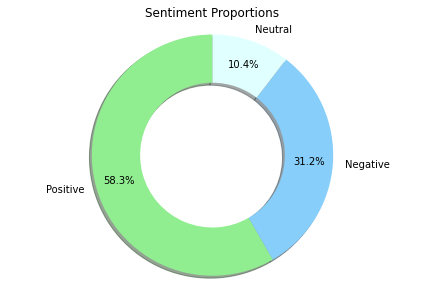

In [12]:
# Plot arguments
sizes = train_df.label.value_counts()
labels = ['Positive', 'Negative', 'Neutral']
colors = ['lightgreen', 'lightskyblue', 'lightcyan']
explode = (0, 0, 0)

# Create axes
f, ax = plt.subplots(figsize = (6, 4))

# plot the chart
pieChart(sizes, ax, 90, labels, colors=colors, explode = explode, shadow = True)
ax.set_title('Sentiment Proportions')

plt.show()

######Around 60% of the texts are positive, with only 10% of it are neutral.

##Text Preprocessing

###Creating methods for preprocessing data

One thing I noticed about the stopwords included in Sastrawi's library is that it also contains words like "tidak, nggak, tetapi, tapi". Those words should not be deleted.

Sentences/phrases like "Tidak suka" which has the label of "negative" will be turned into "suka", while the label is still the same. 

In [13]:
##create function used to change texts to lowercase
def caseFolding(text):
  processed = text.lower()
  return processed

##create function used to remove punctuations
def removePunctuation(text):
  processed = "".join(x for x in text if x not in ("?", ",", ".", ";", "@", ":", "!", "'", "-"))
  return processed

##create function to delete numbers
def removeNumbers(text):
  processed = re.sub(r"\d+", "", text)
  return processed

def tokenizing(text):
  processed = text.split()
  return processed

##create function to delete stopwords
def IDStopwordRemoval(text):
  stopwordFactory = StopWordRemoverFactory()
  stopword = stopwordFactory.get_stop_words()

  stopwords_exclude = ['tidak', 'nggak', 'tetapi', 'tapi']
  for i in stopwords_exclude:
    stopword.remove(i)

  dictionary = ArrayDictionary(stopword)
  stopwords = StopWordRemover(dictionary)

  processed = stopwords.remove(text)

  return processed

##create function to stem words
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def indonesianStemmer(text):
  # creating stemmer
  processed = stemmer.stem(text)
  return processed

###Applying on both train and validation dataset

In [ ]:
##Text Preprocessing for train_df
train_df["teks"] = train_df["teks"].apply(caseFolding)
train_df["teks"] = train_df["teks"].apply(removePunctuation)
train_df["teks"] = train_df["teks"].apply(removeNumbers)
train_df["teks"] = train_df["teks"].apply(IDStopwordRemoval)

In [ ]:
##Text Preprocessing for valid_df
valid_df["teks"] = valid_df["teks"].apply(caseFolding)
valid_df["teks"] = valid_df["teks"].apply(removePunctuation)
valid_df["teks"] = valid_df["teks"].apply(removeNumbers)
valid_df["teks"] = valid_df["teks"].apply(IDStopwordRemoval)

###Stemming process

In [ ]:
#stemming takes a lot of time, so we'll separate the cells
#apply stemmer to the texts
train_df["teks"] = train_df["teks"].apply(indonesianStemmer)
valid_df["teks"] = valid_df["teks"].apply(indonesianStemmer)

In [ ]:
train_df

In [ ]:
valid_df

In [ ]:
##instead of using labels, we assign those labels to numbers from -1 to 1, with 1 being "positive", -1 being "negative", and 0 being "neutral"
train_df["sentiment"] = train_df["label"].apply(lambda label: +1 if label == "positive" else (-1 if label == "negative" else 0))
valid_df["sentiment"] = valid_df["label"].apply(lambda label: +1 if label == "positive" else (-1 if label == "negative" else 0))

In [ ]:
##Saving the dataset so it can be used later
train_df.to_csv(dataset_path+'/dataset_stemmed.csv', header = True, index = False)
valid_df.to_csv(dataset_path+'/valid_stemmed.csv', header = True, index = False)

###Text normalization, changing all slang words into formal

In [14]:
normalized_dict = {}

for index, row in slang_df.iterrows():
    if row[0] not in normalized_dict:
        normalized_dict[row[0]] = row[1]
        
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalized_dict[term] if term in normalized_dict else term for term in list_text]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

def slangNormalization(df):
  processed = df.copy()
  processed.teks = processed.teks.map(normalize_review)

  # delete empty row
  processed.teks.replace('', np.nan, inplace=True)
  processed.teks.replace(' ', np.nan, inplace=True)
  processed.dropna(subset=['teks'], inplace=True)
  return processed

In [ ]:
# take a while
train_df  = slangNormalization(train_df)
valid_df = slangNormalization(valid_df)

In [ ]:
##Overview of the cleaned dataset
train_df

In [ ]:
##Saving once more
train_df.to_csv(dataset_path+'/dataset_normalized.csv', header = True, index = False)
valid_df.to_csv(dataset_path+'/valid_normalized.csv', header = True, index = False)

###Group the preprocessing methods into a single method

In [42]:
def preprocessing(text):
  processed = ""
  processed = caseFolding(text)
  processed = removePunctuation(processed)
  processed = removeNumbers(processed)
  processed = IDStopwordRemoval(processed)
  processed = indonesianStemmer(processed)
  processed = normalize_review(processed)
  return processed

Test on dummy text

In [17]:
text = "Nama saya adalah Daffa. Saya adalah seorang pengembala, dan sedang mencari sesuatu."
print(preprocessing(text))

nama adalah daffa adalah orang pengembala sedang cari


##Importing our Processed Dataset

In [18]:
url = "/content/drive/MyDrive/Kedata/Tugas/1/Dataset/dataset_normalized.csv"
url2 = "/content/drive/MyDrive/Kedata/Tugas/1/Dataset/valid_normalized.csv"
X_train =  pd.read_csv(url)
X_valid = pd.read_csv(url2)

In [19]:
X_train

,teks,label,sentiment
0,warung milik usaha pabrik tahu sudah puluh tah...,positive,1
1,mohon ulama lurus kak mmbri hujjah partai apa ...,neutral,0
2,lokasi strategis jalan sumatera bandung tempat...,positive,1
3,betapa bahagia nya diri saat unboxing paket ba...,positive,1
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,-1
...,...,...,...
10995,tidak kecewa,positive,1
10996,enak rasa masakan nya kepiting senang pilih ke...,positive,1
10997,hormat partaipartai telah koalisi,neutral,0
10998,pagi pagi tol pasteur macet parah bikin jengke...,negative,-1


In [20]:
X_valid

,teks,label,sentiment
0,meski masa kampanye selesai bukan berat habis ...,neutral,0
1,tidak enak,negative,-1
2,restoran tawar makan sunda mes ayam goreng kan...,positive,1
3,lokasi alun alun masakan padang cukup kenal ke...,positive,1
4,betapa bejad kader gerindra anggota dprd cabul...,negative,-1
...,...,...,...
1255,film tncfu tidak cocok tonton tidak suka sadis,negative,-1
1256,indihome mahal loh bayar nya tangan masalah ny...,negative,-1
1257,be dek gea cowok cupu takut pacar nya pacar ny...,negative,-1
1258,valen sangat tidak kualitas konentator nya did...,negative,-1


In [21]:
sentiment_label = X_train.sentiment.factorize()

In [22]:
y_train = pd.DataFrame(X_train.pop("sentiment"))
y_valid = pd.DataFrame(X_valid.pop("sentiment"))
y_valid = y_valid.to_numpy()

In [23]:
y_valid

array([[ 0],
       [-1],
       [ 1],
       ...,
       [-1],
       [-1],
       [ 1]])

In [24]:
y_train

,sentiment
0,1
1,0
2,1
3,1
4,-1
...,...
10995,1
10996,1
10997,0
10998,-1


##Method: Support Vector Machine and Random Forest Classifier

In [25]:
##importing packages needed just for the methods
from sklearn.feature_extraction.text import TfidfVectorizer
import time

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [26]:
##Building the models

def sentimentModel(train_data, train_label, train_valid, method):

  ## Creating the vectorizer, we'll use TF-IDF Vectorizer for both method
  vectorizer = TfidfVectorizer(min_df = 5,
                              max_df = 0.8)
  
  train_vectors = vectorizer.fit_transform(train_data)
  test_vectors = vectorizer.transform(train_valid)

  if method == "RandomForestClassifier":
    classifier = RandomForestClassifier(n_estimators = 200, random_state=0)
    t0 = time.time()

    classifier.fit(train_vectors, train_label)
    t1 = time.time()

    prediction = classifier.predict(test_vectors)
    t2 = time.time()

    time_linear_train = t1 - t0
    time_linear_predict = t2 - t1

    print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

  elif method == "SupportVectorMachine":
    classifier = svm.SVC(kernel = 'poly')
    t0 = time.time()

    classifier.fit(train_vectors, train_label)
    t1 = time.time()

    prediction = classifier.predict(test_vectors)
    t2 = time.time()

    time_linear_train = t1 - t0
    time_linear_predict = t2 - t1

    print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

  return classifier, prediction, vectorizer

In [27]:
def evaluateModel(model, prediction):
  y_pred = pd.DataFrame(prediction, columns = ["label"])
  y_pred["sentiment"] = y_pred["label"].apply(lambda label: +1 if label == "positive" else (-1 if label == "negative" else 0))

  y_pred = pd.DataFrame(y_pred.pop("sentiment"))
  y_pred = y_pred.to_numpy()

  #results
  print("Confusion Matrix: \n")
  print(confusion_matrix(y_valid, y_pred))
  print("\nClassification  Report: \n")
  print(classification_report(y_valid, y_pred))

In [28]:
model, prediction, vectorizer = sentimentModel(X_train['teks'], X_train['label'], X_valid['teks'], method = "SupportVectorMachine")

Training time: 57.057691s; Prediction time: 2.024098s


In [29]:
evaluateModel(model, prediction)

Confusion Matrix: 

[[303   1  90]
 [ 41  25  65]
 [ 31   1 703]]

Classification  Report: 

              precision    recall  f1-score   support

          -1       0.81      0.77      0.79       394
           0       0.93      0.19      0.32       131
           1       0.82      0.96      0.88       735

    accuracy                           0.82      1260
   macro avg       0.85      0.64      0.66      1260
weighted avg       0.83      0.82      0.79      1260



In [39]:
def predict(text, model, vectorizer):

  text = preprocessing(text)
  transformer = vectorizer.transform([text])
  prediction = model.predict(transformer)
  print("Hasil sentiment: " + prediction[0])

  return prediction[0]

In [40]:
list_of_words = ["Halo, nama saya Daffa",
                 "Saya suka coklat",
                 "Kalau misalnya saya lihat mereka bersenang-senang hati saya menjadi sedikit risih",
                 "Coba deh kamu jadi orang yang sedikit rajin biar gak kelihatan banget malasnya",
                 "Bisa gak sih ngelakuinnya? Emang sesusah apa sih?",
                 "Ya memang kalau misalnya kamu gak suka sama dia ya tinggal bilang. Ribet amat.",
                 "Aku coba ngasih saran aja mungkin ya. Soalnya agak sulit juga kalau tiba-tiba hilang gitu",
                 "Gak sakit kok. Udah sembuh",
                 "Iya kemarin ada yang kecelakaan"]
dataframe_words = pd.DataFrame(list_of_words, columns = ["Words"])

In [43]:
dataframe_words["sentiment"] = dataframe_words["Words"].apply(predict, args = (model, vectorizer))
#predict("halo nama saya daffa", model, vectorizer)

Hasil sentiment: negative
Hasil sentiment: positive
Hasil sentiment: negative
Hasil sentiment: negative
Hasil sentiment: negative
Hasil sentiment: negative
Hasil sentiment: negative
Hasil sentiment: negative
Hasil sentiment: negative


In [33]:
dataframe_words

,Words,sentiment
0,"Halo, nama saya Daffa",negative
1,Saya suka coklat,positive
2,Kalau misalnya saya lihat mereka bersenang-sen...,negative
3,Coba deh kamu jadi orang yang sedikit rajin bi...,negative
4,Bisa gak sih ngelakuinnya? Emang sesusah apa sih?,negative
5,Ya memang kalau misalnya kamu gak suka sama di...,negative
6,Aku coba ngasih saran aja mungkin ya. Soalnya ...,negative
7,Gak sakit kok. Udah sembuh,negative
8,Iya kemarin ada yang kecelakaan,negative


##Exporting the model and vectorizer


In [ ]:
import pickle

pickl = {"vectorizer": vectorizer,
         "model": model
         }
pickle.dump(pickl, open('svm_models'+'.p', 'wb'))

In [ ]:
with open("/content/svm_models.p", 'rb') as pickled:
    data = pickle.load(pickled)
model = data["model"]
vectorizer = data["vectorizer"]

In [ ]:
vector = vectorizer.transform(["Film ini bagus sekali"])
prediction = model.predict(vector)
response = prediction[0]
print(response)

positive
